# SK Learn ML Pipeline (All IBD)

## Overview
This notebook implements a comprehensive machine learning pipeline for predicting IBD-associated fatigue using scikit-learn models. The pipeline includes data preprocessing, model selection, hyperparameter tuning, evaluation, and interpretability analysis.

## Pipeline Steps
1. Load and preprocess IBD patient data (can be configured to use either all IBD patients or only those in biochemical remission)
2. Integrate with DNN metrics from companion notebooks for comparison
3. Standardize numerical features and split data preserving patient grouping
4. Perform hyperparameter tuning via grid search with group k-fold cross-validation
5. Train and evaluate six different models:
   - Random Forest
   - Logistic Regression
   - AdaBoost
   - XGBoost
   - MLPClassifier
   - SVC
6. Generate ROC curves and performance metrics (accuracy, sensitivity, specificity, AUC)
7. Perform SHAP analysis for model interpretability

## Requirements
- Requires source code from `src` directory
- For DNN comparison, run notebooks `2_dnn.ipynb` and/or `3_dnn_biochemical_remission.ipynb` first

In [1]:
import pandas as pd
import numpy as np
import json
import joblib
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

from src.config.constants import NUMERICAL_FEATURES, RANDOM_SEED
from src.config.paths import (
    SKLEARN_BIOCHEM_REMISSION_DIR,
    SKLEARN_DIR,
    DNN_DIR,
    DNN_BIOCHEM_REMISSION_DIR,
)
from src.config.sklearn_models import models_and_params
from src.data.preprocessing import (
    load_and_preprocess_data,
    remove_low_value_features,
    fix_numerical_features_for_production,
)
from src.data.splitting import split_data_for_sklearn
from src.models.sklearn_utils import perform_grid_search, evaluate_model
from src.visualization.plotting import plot_roc_curves
from src.visualization.shap import create_shap_plot, create_shap_grid

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pipeline Configuration

In [2]:
biochemical_remission = False
random_seed = RANDOM_SEED
models_and_params = models_and_params

if biochemical_remission:
    output_path = SKLEARN_BIOCHEM_REMISSION_DIR
    models_dir = SKLEARN_BIOCHEM_REMISSION_DIR / "exports"
    cmap = "berlin"
    df = load_and_preprocess_data(biochemical_remission=True)
else:
    output_path = SKLEARN_DIR
    models_dir = SKLEARN_DIR / "exports"
    cmap = "seismic"
    df = load_and_preprocess_data(biochemical_remission=False)

## Load DNN Metrics for Combined Visualization

This loads DNN metrics from 2_dnn and 3_dnn_biochemical_remission python notebooks. You need to run those notebooks first to generate the metrics. If not available, the plots will continue without the DNN metrics.

In [3]:
try:
    if biochemical_remission:
        read_dir = DNN_BIOCHEM_REMISSION_DIR / "metrics"
    else:
        read_dir = DNN_DIR / "metrics"

    # Try loading FPR and TPR data
    try:
        dnn_fpr = np.loadtxt(read_dir / "dnn_fpr.txt")
        dnn_tpr = np.loadtxt(read_dir / "dnn_tpr.txt")
    except (FileNotFoundError, IOError) as e:
        print(f"Warning: Could not load DNN ROC curve data: {e}")
        dnn_fpr = None
        dnn_tpr = None

    # Try loading metrics from JSON file
    try:
        with open(read_dir / "dnn_metrics.json", "r") as f:
            dnn_metrics = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Warning: Could not load DNN metrics JSON: {e}")
        dnn_metrics = {
            "accuracy": None,
            "sensitivity": None,
            "specificity": None,
            "auc": None,
        }

    print("Successfully loaded DNN metrics for comparison")

except Exception as e:
    print(f"Error loading DNN metrics: {e}")
    print("Will continue without DNN comparison")
    dnn_fpr = None
    dnn_tpr = None
    dnn_metrics = {
        "accuracy": None,
        "sensitivity": None,
        "specificity": None,
        "auc": None,
    }

Successfully loaded DNN metrics for comparison


In [4]:
# We removed low value features here and simplified the model
df = remove_low_value_features(df)
numerical_features = NUMERICAL_FEATURES
numerical_features = fix_numerical_features_for_production(numerical_features)

## Data Loading, Splitting and Cross Validation Setup

In [5]:
scaler = StandardScaler()
scaler.fit(df[numerical_features])
df[numerical_features] = scaler.transform(df[numerical_features])

In [6]:
X_train, X_test, y_train, y_test, groups = split_data_for_sklearn(df)

In [7]:
# Save the scaler
scaler_path = models_dir / "scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

# Save feature names for reference
with open(models_dir / "feature_names.json", "w") as f:
    json.dump({"features": list(X_train.columns)}, f)
print(f"Saved feature names to {models_dir / 'feature_names.json'}")

Scaler saved to /Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/output/all_ibd/sklearn/exports/scaler.pkl
Saved feature names to /Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/output/all_ibd/sklearn/exports/feature_names.json


In [8]:
cv = GroupKFold(n_splits=5)

## Hyperparameter Tuning

Find the best hyperparameters for each of the six models using grid search. The hyperparameters are defined in `src/config/sklearn_models.py` file.

In [9]:
results = perform_grid_search(models_and_params, X_train, y_train, groups, cv)
results_df = pd.DataFrame(results).T
print(results_df)

Running GridSearch for Random Forest...
Running GridSearch for Logistic Regression...
Running GridSearch for AdaBoost...
Running GridSearch for XGBoost...
Running GridSearch for SVC...
Running GridSearch for MLPClassifier...
                                                           best_params  \
Random Forest        {'max_depth': 5, 'min_samples_split': 20, 'n_e...   
Logistic Regression        {'C': 1, 'penalty': 'l2', 'solver': 'saga'}   
AdaBoost                   {'learning_rate': 0.1, 'n_estimators': 100}   
XGBoost              {'learning_rate': 0.01, 'max_depth': 3, 'n_est...   
SVC                                          {'C': 10, 'gamma': 0.001}   
MLPClassifier        {'activation': 'tanh', 'hidden_layer_sizes': (...   

                    mean_score std_score  \
Random Forest         0.768425  0.017182   
Logistic Regression   0.767848   0.03227   
AdaBoost              0.765884    0.0117   
XGBoost               0.760948  0.010522   
SVC                   0.770778  0.02

## Final Model Training and Evaluation

We will now fit the final models using the best hyperparameters found in the previous step and will evaluate the models on the test set.

In [10]:
# Initialize results storage
fitted_models = {}
roc_results = {}  # For plotting ROC curves
metrics_results = []  # For creation of metrics table

for model_name, (model, _) in models_and_params.items():
    # Get the best parameters from grid search
    best_params = results[model_name]["best_params"]
    best_model = model.set_params(**best_params)

    # Evaluate model performance
    print(f"Evaluating {model_name}...")
    evaluation = evaluate_model(
        best_model, X_train, X_test, y_train, y_test, groups, cv
    )

    # The fitted model is now available in evaluation["model"]
    fitted_model = evaluation["model"]

    # Save the model AFTER it has been fitted
    model_path = models_dir / f"{model_name.replace(' ', '_').lower()}_model.joblib"
    joblib.dump(fitted_model, model_path)
    print(f"Saved {model_name} model to {model_path}")

    # Store the fitted model
    fitted_models[model_name] = evaluation["model"]

    # Store the ROC results
    roc_results[model_name] = {
        "fpr": evaluation["fpr"],
        "tpr": evaluation["tpr"],
        "test_auc": evaluation["test_auc"],
        "mean_auc": evaluation["mean_auc"],
        "std_auc": evaluation["std_auc"],
    }

    # Store the metrics
    metrics_results.append(
        {
            "Model": model_name,
            "Accuracy": evaluation["accuracy"],
            "Sensitivity (Recall)": evaluation["sensitivity"],
            "Specificity": evaluation["specificity"],
            "AUC": evaluation["test_auc"],
        }
    )

Evaluating Random Forest...
Saved Random Forest model to /Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/output/all_ibd/sklearn/exports/random_forest_model.joblib
Evaluating Logistic Regression...
Saved Logistic Regression model to /Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/output/all_ibd/sklearn/exports/logistic_regression_model.joblib
Evaluating AdaBoost...
Saved AdaBoost model to /Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/output/all_ibd/sklearn/exports/adaboost_model.joblib
Evaluating XGBoost...
Saved XGBoost model to /Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/output/all_ibd/sklearn/exports/xgboost_model.joblib
Evaluating SVC...
Saved SVC model to /Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/output/all_ibd/sklearn/exports/svc_model.joblib
Evaluating MLPClassifier...
Saved MLPClassifier model to /Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/output/all_ibd/sk

### Combined ROC Curves

For all models including the DNN model trained in previous notebooks.

ROC curves saved to /Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/output/all_ibd/sklearn/plots/combined_roc_curves.png
ROC curves plotted successfully. DNN data included: True


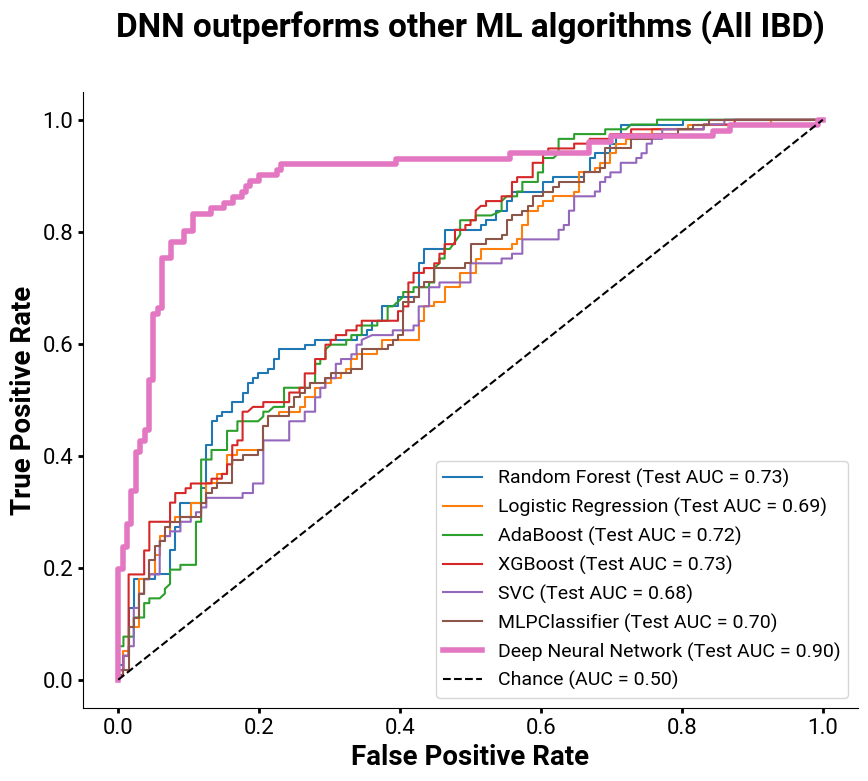

In [11]:
plot_roc_curves(
    roc_results,
    dnn_fpr=dnn_fpr,
    dnn_tpr=dnn_tpr,
    dnn_metrics=dnn_metrics,
    biochemical_remission=biochemical_remission,
    output_path=output_path,
)

### Export Metrics to CSV File

Creates a table for easy inclusion in the paper.

In [12]:
# Add in DNN Metrics Here if available
if all(v is not None for v in dnn_metrics.values()):
    metrics_results.append(
        {
            "Model": "Deep Neural Network",
            "Accuracy": dnn_metrics["accuracy"],
            "Sensitivity (Recall)": dnn_metrics["sensitivity"],
            "Specificity": dnn_metrics["specificity"],
            "AUC": dnn_metrics["auc"],
        }
    )
    print("Added DNN metrics to comparison table")
else:
    print("Skipping DNN in metrics table - data not available")

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_results).sort_values("AUC", ascending=False)
metrics_df = metrics_df.round(3)

# Save to CSV
save_path = output_path / "metrics" / "combined_model_metrics.csv"
metrics_df.to_csv(save_path, index=False)
print(f"Metrics saved to {save_path}")

Added DNN metrics to comparison table
Metrics saved to /Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/output/all_ibd/sklearn/metrics/combined_model_metrics.csv


## SHAP Analysis

### SHAP Explainer Configuration

In [13]:
shap_config = {
    "Random Forest": {"model": fitted_models["Random Forest"], "type": "tree"},
    "Logistic Regression": {
        "model": fitted_models["Logistic Regression"],
        "type": "linear",
    },
    "AdaBoost": {
        "model": fitted_models["AdaBoost"],
        "type": "kernel",
        "sample_size": 50,
    },
    "XGBoost": {"model": fitted_models["XGBoost"], "type": "xgboost"},
    "MLPClassifier": {
        "model": fitted_models["MLPClassifier"],
        "type": "kernel",
        "sample_size": 50,
    },
    "SVC": {"model": fitted_models["SVC"], "type": "kernel", "sample_size": 40},
}


### SHAP Summary Plots for All Models

Creating SHAP plot for Random Forest...


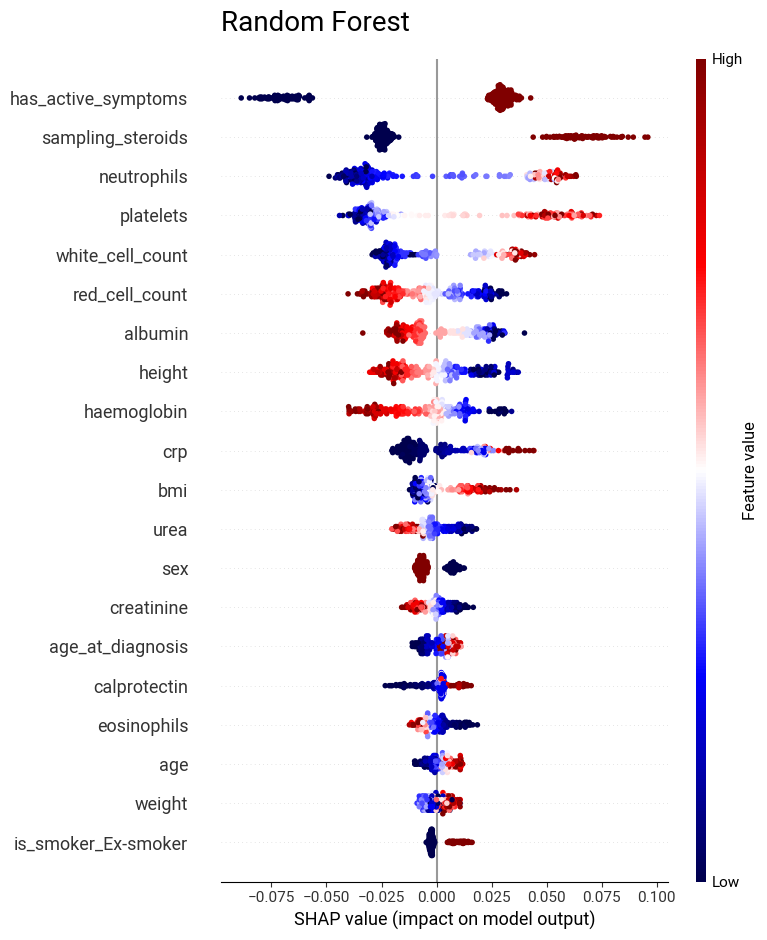

Creating SHAP plot for Logistic Regression...


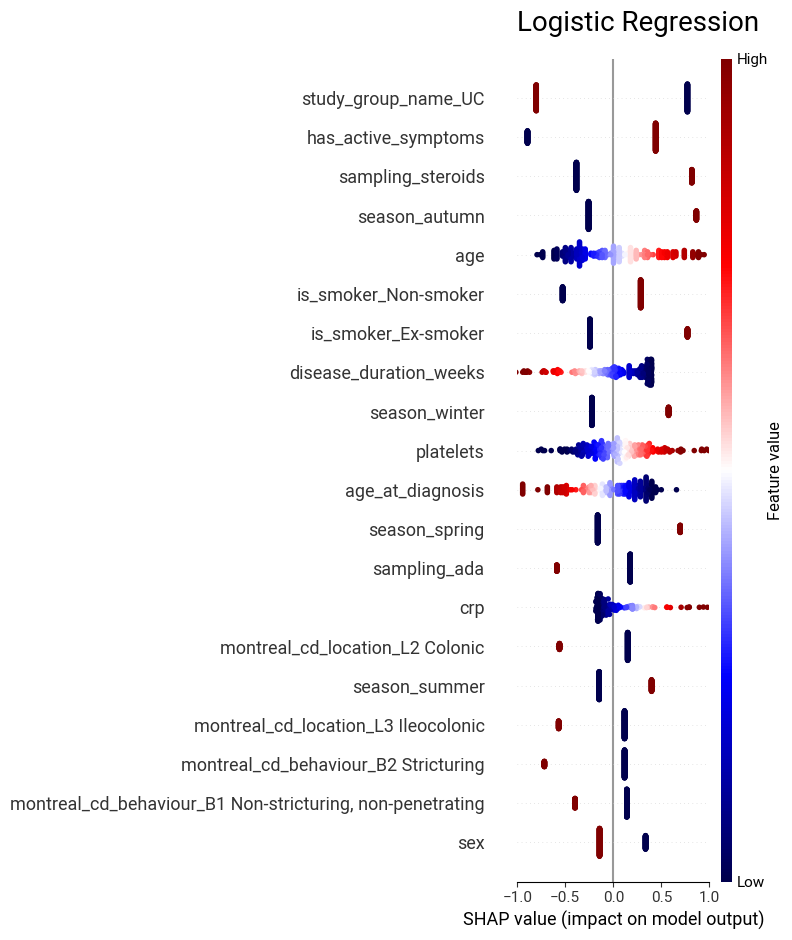

Creating SHAP plot for AdaBoost...


100%|██████████| 50/50 [00:43<00:00,  1.16it/s]


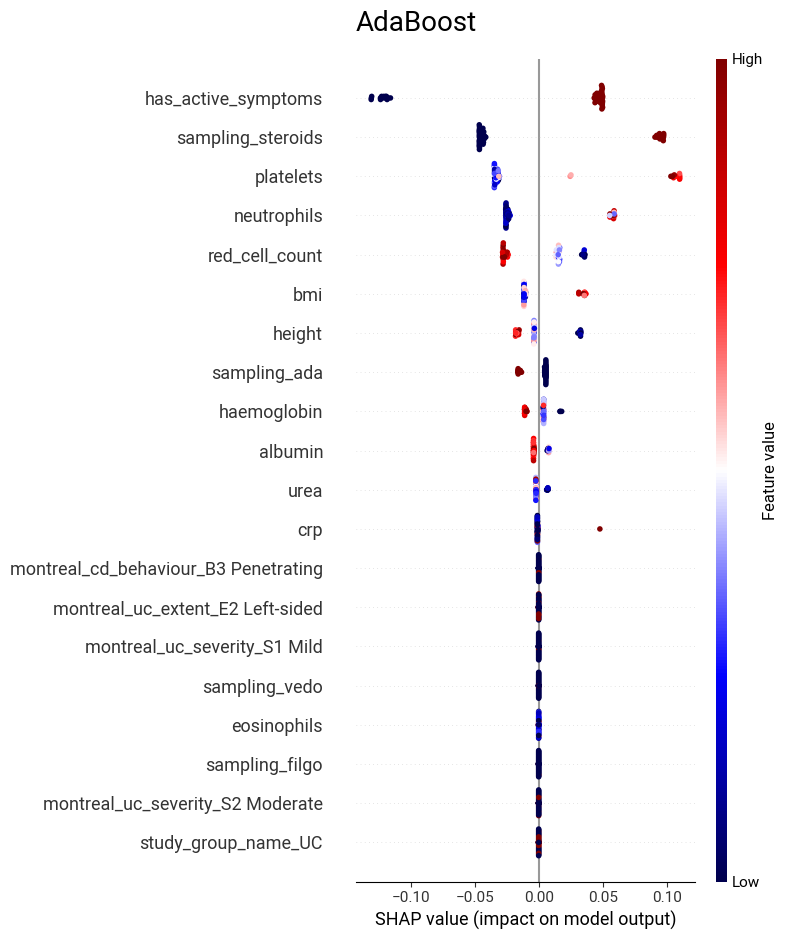

Creating SHAP plot for XGBoost...


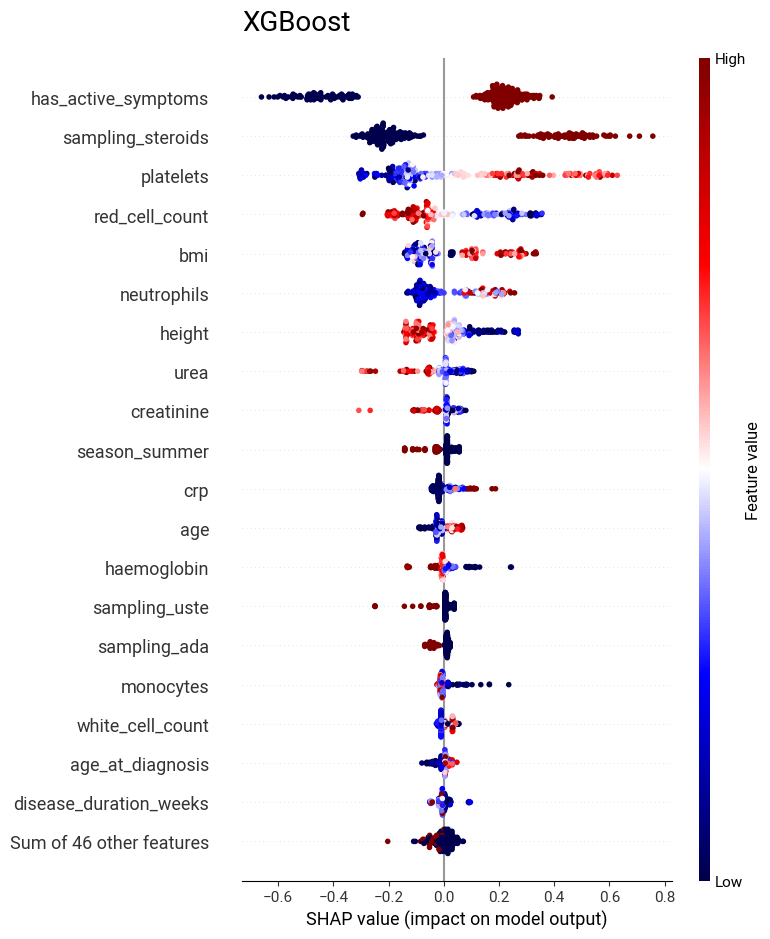

Creating SHAP plot for MLPClassifier...


100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


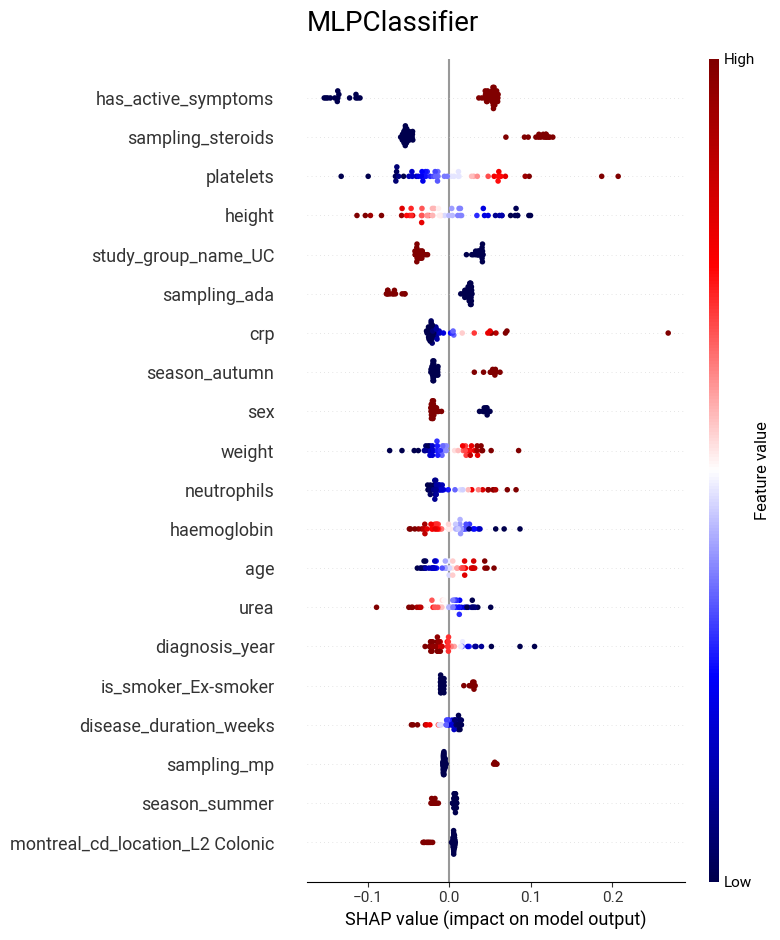

Creating SHAP plot for SVC...


100%|██████████| 40/40 [02:24<00:00,  3.60s/it]


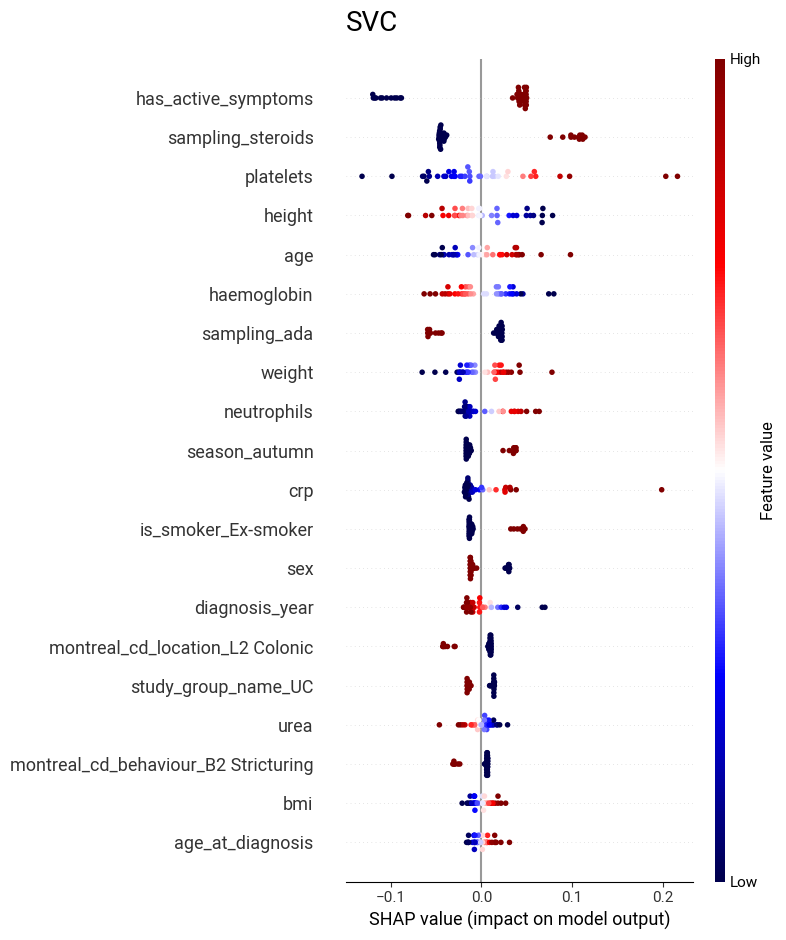

In [14]:
for model_name, config in shap_config.items():
    print(f"Creating SHAP plot for {model_name}...")
    create_shap_plot(
        config["model"],
        X_test,
        model_name,
        cmap,
        output_path,
        sample_size=config.get("sample_size"),
        model_type=config["type"],
    )

### Arrange SHAP Plots in a Grid

For inclusion in appendix.

In [15]:
load_path = output_path / "plots"
save_path = output_path / "plots" / "shap_grid_comparison.png"
create_shap_grid(load_path, save_path)

Grid image created at /Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/output/all_ibd/sklearn/plots/shap_grid_comparison.png
